# Variational Autoencoders

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))
    ])

transform = transforms.ToTensor()

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

data_loader = torch.utils.data.DataLoader(dataset=mnist_data,
                                          batch_size=64,
                                          shuffle=True)

mnist_data_valid = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

data_loader_valid = torch.utils.data.DataLoader(dataset=mnist_data_valid,
                                          batch_size=64,
                                          shuffle=True)                        

In [3]:
dataiter = iter(data_loader)
images, labels = dataiter.next()
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


In [4]:
'''
class VAE(nn.Module):
    def __init__(self):
        super().__init__()        
        self.c1 = nn.Conv2d(1, 16, 3, stride=2, padding=1)
        self.c2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        self.c3 = nn.Conv2d(32, 64, 7)
        self.l1_mu = nn.Linear(64, 64)
        self.l1_sigma = nn.Linear(64, 64)
        self.c4 = nn.ConvTranspose2d(64, 32, 7)
        self.c5 = nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1)
        self.c6 = nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1)

    def forward(self, x):
        x = self.c1(x)
        x = F.relu(x)
        x = self.c2(x)
        x = F.relu(x)
        x = self.c3(x)
        x = F.relu(x)
        y = x.view(-1, 64)
        
        # VAE 
        mu = self.l1_mu(y)
        sigma = self.l1_sigma(y)        
        x = torch.randn_like(x) * sigma.view(-1, 64, 1, 1) + mu.view(-1, 64, 1, 1)

        x = self.c4(x)
        x = F.relu(x)
        x = self.c5(x)
        x = F.relu(x)
        x = self.c6(x)
        x = torch.sigmoid(x)
        return x, mu, sigma
 '''

'\nclass VAE(nn.Module):\n    def __init__(self):\n        super().__init__()        \n        self.c1 = nn.Conv2d(1, 16, 3, stride=2, padding=1)\n        self.c2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)\n        self.c3 = nn.Conv2d(32, 64, 7)\n        self.l1_mu = nn.Linear(64, 64)\n        self.l1_sigma = nn.Linear(64, 64)\n        self.c4 = nn.ConvTranspose2d(64, 32, 7)\n        self.c5 = nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1)\n        self.c6 = nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1)\n\n    def forward(self, x):\n        x = self.c1(x)\n        x = F.relu(x)\n        x = self.c2(x)\n        x = F.relu(x)\n        x = self.c3(x)\n        x = F.relu(x)\n        y = x.view(-1, 64)\n        \n        # VAE \n        mu = self.l1_mu(y)\n        sigma = self.l1_sigma(y)        \n        x = torch.randn_like(x) * sigma.view(-1, 64, 1, 1) + mu.view(-1, 64, 1, 1)\n\n        x = self.c4(x)\n        x = F.relu(x)\n        x = self.c

In [5]:
class VAE(nn.Module):
    def __init__(self, latent_dims=64):
        super(VAE, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear_mu = nn.Linear(512, latent_dims)
        self.linear_sigma = nn.Linear(512, latent_dims)
        self.linear2 = nn.Linear(latent_dims, 512)
        self.linear3 = nn.Linear(512, 784)

    def encoder(self, x):
        x = F.relu(self.linear1(x))
        mu =  self.linear_mu(x)
        sigma = torch.exp(self.linear_sigma(x))
        z = torch.randn_like(mu) * sigma + mu
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

    def decoder(self, z):
        z = F.relu(self.linear2(z))
        z = torch.sigmoid(self.linear3(z))
        return z

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)
        


In [6]:
# device = ('cuda' if torch.cuda.is_available() else 'cpu')
# model = VAE_Autoencoder().to(device)
model = VAE(64) #.to(device)

criterion = nn.MSELoss(reduction='sum')    
optimizer = torch.optim.Adam(model.parameters() )#,
                             #lr=1e-2, 
                             #weight_decay=1e-5)

In [7]:
# Point to training loop video
num_epochs = 5
outputs = []

for epoch in range(num_epochs):
    for (img, _) in data_loader:
        # img = img.to(device)
        img = img.view(-1, 784)
        recon = model(img)
        loss = criterion(recon, img) + model.kl
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss:1868.1932
Epoch:2, Loss:1908.1876
Epoch:3, Loss:1743.1204
Epoch:4, Loss:1674.8647
Epoch:5, Loss:1720.0000


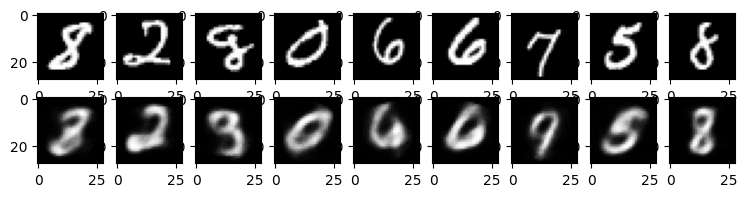

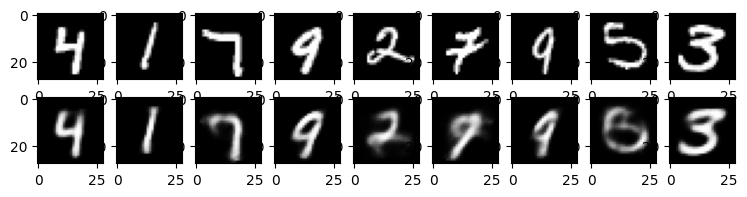

In [8]:
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().cpu().numpy()
    recon = outputs[k][2].detach().cpu().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])

## Pruebas sobre el conjunto de validación

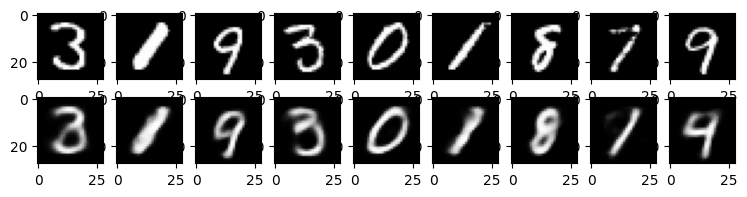

In [9]:
model.eval()

dataiter = iter(data_loader_valid)
images, labels = dataiter.next()

img = images[0]

plt.figure(figsize=(9, 2))
plt.gray()

for i, img in enumerate(images[:9]):
    with torch.no_grad():
        img = img.view(-1, 784)
        recon = model(img)
        recon = recon.view(-1, 28, 28)
        recon = recon.detach().numpy()
        plt.subplot(2, 9, i+1)
        plt.imshow(img.view(28, 28))
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(recon[0])


tensor([8, 2, 0, 4])


/var/folders/gm/03tk2cn52jzgnlz4qchk9s9m0000gn/T/ipykernel_12171/1832619519.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = model.encoder(torch.tensor(images.view(-1, 784))).detach().numpy()


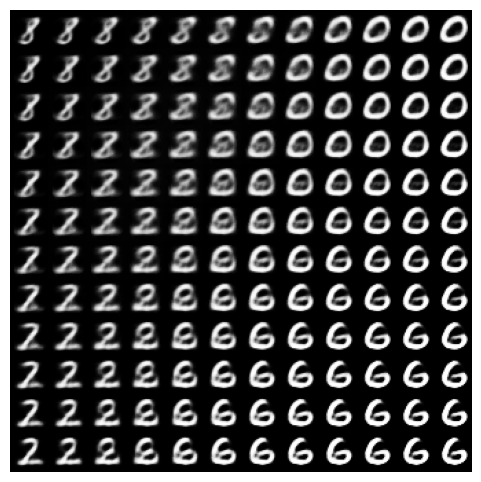

In [124]:
import numpy as np

def plot_reconstructed(autoencoder, z1, z2, z3, z4, n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i in range(n):
        for j in range(n):
            z = z1 + (z2 - z1) * i / n + (z3 - z1) * j / n + (z4 - z1) * i * j / n**2
            with torch.no_grad():
                recon = autoencoder.decoder(torch.from_numpy(z).float())
                recon = recon.view(-1, 28, 28)
                recon = recon.detach().numpy()
                img[i*w:(i+1)*w, j*w:(j+1)*w] = recon[0]
    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

model.eval()

dataiter = iter(data_loader_valid)
images, labels = dataiter.next()
print(labels[1:5])
z = model.encoder(torch.tensor(images.view(-1, 784))).detach().numpy()

plot_reconstructed(model, z[1], z[2], z[3], z[4])

### Ejercicios

Calcula las medias y desviaciones de cada categoría en el espacio latente de un autoencoder y de un VAE.

